In [1]:
from astro.load import DataConfig, Loader, GroupSessionData, GroupDataloader
from astro.transforms import GroupSplitter


from astro.preprocess import (
    PreprocessConfig,
    AlignmentPreprocessor,
    GroupedEventPreprocessor,
    NeuronDropper,
)

from astro.atd_decode import (
    ATDPrepConfig,
    ModelConfig,
    ATDDataGetter,
    ATDEventGetter,
    ATDTargeGetter,
    ATDTimeSubsetter,
    DecoderCV,
    ATDPrepper,
    ATDDecodeRunner,
    latency_mask_factory,
)
from astro.atd_decode.analyses import (
    AllNeurons,
    IncreasingNeuronNumber,
    NeuronDrop,
    IncreasingPCNumber,
)

from trace_minder.preprocess import TracePreprocessor
from trace_minder.align import GroupedAligner
from trace_minder.surrogates import Rotater, TraceSampler


from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import BaseCrossValidator


from dataclasses import dataclass
from typing import Callable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy
import os
from pathlib import Path
from astro.config import Config

In [2]:
notebook_path = Path(os.getcwd())
root_path = notebook_path.parent.parent
env_path = root_path / ".env"

paths = Config.from_env(env_path)

OUTPUT_DIR = paths.derived_data_dir / "atd_decoding"
OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [3]:
# Load config

loader = Loader(data_dir=paths.data_dir)

group_splitter = GroupSplitter(
    df_mice=loader.load_mice(),
    df_neurons=loader.load_neurons(),
    excluded_groups=["VEH-VEH"],
    permute_neurons=False,
    equalize_neuron_numbers=False,
)

data_config_veh = DataConfig(
    loader=loader,
    session_name="ret",
    group="VEH-CNO",
    block_group="CS",
    group_splitter=group_splitter,
)
data_config_cno = deepcopy(data_config_veh)
data_config_cno.group = "CNO-VEH"


data_loader_veh = GroupDataloader(data_config_veh)
data_loader_cno = GroupDataloader(data_config_cno)

In [4]:
# Preprocess Config

initial_aligner = GroupedAligner(
    t_before=30,
    t_after=30,
    df_wide_group_mapper=group_splitter.neurons_by_mouse,
    df_events_event_time_col="start_time",
    df_events_group_col="mouse_name",
)
trace_preprocessor = TracePreprocessor(
    max_time=600,
    standardize=False,
    medfilt_kernel_size=None,
    resample_frequency=0.1,
)
event_preprocessor = GroupedEventPreprocessor(
    first_x_events=5,
)

trace_rotator = Rotater(time_col="time", copy=True)
trace_sampler = TraceSampler(
    time_col="time", frac_retained=None, n_retained=None, with_replacement=False
)

preprocess_config = PreprocessConfig(
    aligner=initial_aligner,
    trace_preprocessor_load=trace_preprocessor,
    event_preprocessor=event_preprocessor,
    trace_preprocessor_post_alignment=None,
    # trace_rotator=trace_rotator,
    trace_sampler=None,
)
preprocessor = AlignmentPreprocessor(preprocess_config)

In [5]:
# ATD Prep

pre_mask = latency_mask_factory(-5, 0)
post_mask = latency_mask_factory(0, 5)

atd_time_subsetter = ATDTimeSubsetter(pre_masker=pre_mask, post_masker=post_mask)
atd_data_getter = ATDDataGetter()
atd_event_getter = ATDEventGetter()
atd_target_getter = ATDTargeGetter(
    pre_masker=pre_mask,
    post_masker=post_mask,
)

atd_config = ATDPrepConfig(
    data_getter=atd_data_getter,
    group_getter=atd_event_getter,
    target_getter=atd_target_getter,
    time_subsetter=atd_time_subsetter,
)
atd_prepper = ATDPrepper(atd_config)

In [6]:
# Model Config

model = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(max_iter=2000, C=2)),
    ]
)
cv = LeaveOneGroupOut()
scorer = "f1_macro"

model_config = ModelConfig(model=model, cv=cv, scoring=scorer, n_jobs=-1)
decoder = DecoderCV(model_config)

## All Neurons

1) Overall 
2) Rotation Surrogates

In [7]:
obs_results = {}
obs_scores = {}
bs_reps = {}

for data_loader in [data_loader_veh, data_loader_cno]:
    group_name = data_loader.data_config.group
    print(f"Running {group_name}")

    base_runner = ATDDecodeRunner(data_loader, preprocessor, atd_prepper, decoder)
    experiment = AllNeurons(base_runner, n_rotations=5, n_group_permutations=None)

    results = experiment.run()

    obs_results[group_name] = results["observed"]
    obs_scores[group_name] = results["observed"]["test_score"]
    bs_reps[group_name] = np.array([r["test_score"].mean() for r in results["rotated"]])

Running VEH-CNO


Trace Rotations: 100%|██████████| 5/5 [00:04<00:00,  1.17it/s]


Running CNO-VEH


Trace Rotations: 100%|██████████| 5/5 [00:03<00:00,  1.29it/s]


In [8]:
dfs = []
for data_loader in [data_loader_veh, data_loader_cno]:
    print(f"Running {data_loader.data_config.group}")
    group_name = data_loader.data_config.group
    neurons = data_loader.group_session_data.df_traces.columns[1:].tolist()
    coefs = [mod.steps[-1][-1].coef_ for mod in obs_results[group_name]["estimator"]]
    coef_res = []
    for i, coef in enumerate(coefs):
        coef_map = [{"neuron": n, "coef": c} for n, c in zip(neurons, coef.flatten())]

        coef_df = pd.DataFrame(coef_map)
        coef_df["cv_fold"] = i
        coef_df["group"] = group_name
        coef_res.append(coef_df)

    df_coef_group = pd.concat(coef_res)
    dfs.append(df_coef_group)

df_coef = pd.concat(dfs)

Running VEH-CNO
Running CNO-VEH


In [9]:
def dict_to_df(d: dict) -> pd.DataFrame:
    return (
        pd.Series(d)
        .explode()
        .to_frame("score")
        .reset_index()
        .rename(columns={"index": "group"})
    )


df_res_obs = dict_to_df(obs_scores)
display(df_res_obs.groupby("group")["score"].mean())

df_res_bs = dict_to_df(bs_reps)
display(df_res_bs.groupby("group")["score"].mean())

group
CNO-VEH     0.67776
VEH-CNO    0.885447
Name: score, dtype: object

group
CNO-VEH    0.406407
VEH-CNO    0.467651
Name: score, dtype: object

In [10]:
df_res_obs.to_csv(OUTPUT_DIR / "all_neurons_observed_scores.csv", index=False)
df_res_bs.to_csv(OUTPUT_DIR / "all_neuronsbs_reps.csv", index=False)

df_coef.to_csv(OUTPUT_DIR / "all_neurons_coefs.csv", index=False)

## Increasing Number of Neurons

In [37]:
obs_results = {}
obs_scores = {}
bs_reps = {}

for data_loader in [data_loader_veh, data_loader_cno]:
    group_name = data_loader.data_config.group
    print(f"Running {group_name}")

    base_runner = ATDDecodeRunner(data_loader, preprocessor, atd_prepper, decoder)
    experiment = IncreasingNeuronNumber(
        base_runner, min_neurons=2, max_neurons=100, n_samples=50
    )

    results = experiment.run()

    obs_results[group_name] = results["observed"]

Running VEH-CNO


neuron_number: 100%|██████████| 99/99 [21:05<00:00, 12.78s/it]


Running CNO-VEH


neuron_number: 100%|██████████| 99/99 [21:26<00:00, 13.00s/it]


In [38]:
df_res_neuron_number = pd.concat(
    [
        obs_results["CNO-VEH"].assign(group="CNO-VEH"),
        obs_results["VEH-CNO"].assign(group="VEH-CNO"),
    ]
)

display(df_res_neuron_number.groupby(["group", "neuron_number"]).mean().reset_index())

,group,neuron_number,sample_idx,mean_test_score
0,CNO-VEH,2,24.5,0.494238
1,CNO-VEH,3,24.5,0.529507
2,CNO-VEH,4,24.5,0.515228
3,CNO-VEH,5,24.5,0.552336
4,CNO-VEH,6,24.5,0.572418
...,...,...,...,...
193,VEH-CNO,96,24.5,0.770197
194,VEH-CNO,97,24.5,0.781083
195,VEH-CNO,98,24.5,0.806953
196,VEH-CNO,99,24.5,0.780990


/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/opt/miniconda3/envs/astro/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype

<Axes: xlabel='neuron_number', ylabel='mean_test_score'>

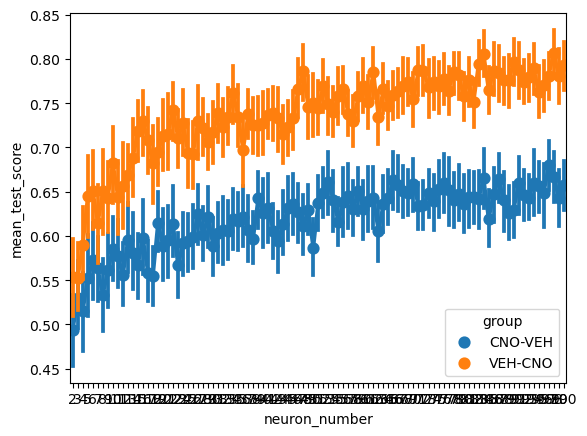

In [40]:
import seaborn as sns

sns.pointplot(
    data=df_res_neuron_number,
    x="neuron_number",
    y="mean_test_score",
    hue="group",
    # ci="",
)

In [41]:
df_res_neuron_number.to_csv(OUTPUT_DIR / "neuron_number_scores.csv", index=False)

In [8]:
rot_results = {}
rot_scores = {}
bs_reps = {}

for data_loader in [data_loader_veh, data_loader_cno]:
    group_name = data_loader.data_config.group
    print(f"Running {group_name}")

    base_runner = ATDDecodeRunner(data_loader, preprocessor, atd_prepper, decoder)
    experiment = IncreasingNeuronNumber(
        base_runner,
        min_neurons=2,
        max_neurons=100,
        n_samples=50,
        run_obs=False,
        run_rot=True,
    )

    results = experiment.run()

    rot_results[group_name] = results["rotated"]

df_res_neuron_number_rot = pd.concat(
    [
        rot_results["CNO-VEH"].assign(group="CNO-VEH"),
        rot_results["VEH-CNO"].assign(group="VEH-CNO"),
    ]
)

Running VEH-CNO


neuron_number: 100%|██████████| 99/99 [22:17<00:00, 13.51s/it]


Running CNO-VEH


neuron_number: 100%|██████████| 99/99 [22:20<00:00, 13.54s/it]


In [ ]:
df_res_neuron_number_rot.to_csv(
    OUTPUT_DIR / "neuron_number_scores_rot.csv", index=False
)

## Neuron Type Drop

In [7]:
clustering_dir = paths.derived_data_dir / "clustering"

types_veh = pd.read_excel(
    clustering_dir / "ret_clustering_results.xlsx", sheet_name="VEH-CNO_cluster_map"
)
types_cno = pd.read_excel(
    clustering_dir / "ret_clustering_results.xlsx", sheet_name="CNO-VEH_cluster_map"
)

type_mapper_veh = (
    types_veh.groupby("cluster")["cell_id"]
    .apply(lambda x: np.unique(x).astype(str))
    .to_dict()
)
type_mapper_cno = (
    types_cno.groupby("cluster")["cell_id"]
    .apply(lambda x: np.unique(x).astype(str))
    .to_dict()
)

In [8]:
neuron_dropper_veh = NeuronDropper(neuron_to_drop=np.array([0, 1]))
neuron_dropper_cno = NeuronDropper(neuron_to_drop=np.array([0, 1]))

preprocessor_veh = deepcopy(preprocessor)
preprocessor_cno = deepcopy(preprocessor)

preprocessor_veh.preprocess_config.neuron_dropper = neuron_dropper_veh
preprocessor_cno.preprocess_config.neuron_dropper = neuron_dropper_cno

In [9]:
obs_results = {}
boot_results = []

for data_loader, preprocessor, type_mapper in zip(
    [data_loader_veh, data_loader_cno],
    [preprocessor_veh, preprocessor_cno],
    [type_mapper_veh, type_mapper_cno],
):
    group_name = data_loader.data_config.group
    print(f"Running {group_name}")

    base_runner = ATDDecodeRunner(data_loader, preprocessor, atd_prepper, decoder)
    experiment = NeuronDrop(base_runner, type_mapper, n_permutations=20)
    results = experiment.run()

    obs_results[group_name] = results["observed"]
    boot_results.append(results["permuted"].assign(group=group_name))

df_neuron_drop_boot = pd.concat(boot_results)

Running VEH-CNO


Neuron Drop Permutations: 100%|██████████| 20/20 [01:03<00:00,  3.19s/it]


Running CNO-VEH


Neuron Drop Permutations: 100%|██████████| 20/20 [01:06<00:00,  3.35s/it]


In [26]:
res = []
for group_name, results in obs_results.items():
    for cluster_type, cluster_results in results.items():
        scores = cluster_results["test_score"]
        group_data = [group_name] * len(scores)
        cluster = [cluster_type] * len(scores)
        cv_idx = np.arange(1, len(scores) + 1)

        res.append(
            pd.DataFrame(
                {
                    "group": group_data,
                    "score": scores,
                    "cv_idx": cv_idx,
                    "cluster_dropped": cluster_type,
                }
            )
        )

df_neuron_drop_obs = pd.concat(res)

In [28]:
df_neuron_drop_boot.to_csv(OUTPUT_DIR / "neuron_drop_boot_strap.csv", index=False)
df_neuron_drop_obs.to_csv(OUTPUT_DIR / "neuron_drop_observed.csv", index=False)

## By PC

In [7]:
from sklearn.decomposition import PCA


model_pca = Pipeline(
    steps=[
        ("scaler", StandardScaler(with_mean=True, with_std=False)),
        ("pca", PCA(n_components=2)),
        ("classifier", LogisticRegression(max_iter=2000, C=0.5)),
    ]
)


model_config_pca = ModelConfig(model=model_pca, cv=cv, scoring=scorer, n_jobs=-1)
decoder_pca = DecoderCV(model_config_pca)

In [8]:
result_dict = {}

for dataloader in [data_loader_veh, data_loader_cno]:
    group_name = dataloader.data_config.group
    print(f"Running {group_name}")

    base_runner = ATDDecodeRunner(dataloader, preprocessor, atd_prepper, decoder_pca)
    experiment = IncreasingPCNumber(
        base_runner, min_pc=1, max_pc=50, n_rotations=75, run_obs=True, run_rot=False
    )
    results = experiment.run()
    result_dict[group_name] = results

df_pca = pd.concat(
    [
        result_dict["CNO-VEH"]["observed"].assign(group="CNO-VEH"),
        result_dict["VEH-CNO"]["observed"].assign(group="VEH-CNO"),
    ]
)

Running VEH-CNO


pc_number-observed:   0%|          | 0/50 [00:00<?, ?it/s]

pc_number-observed: 100%|██████████| 50/50 [00:39<00:00,  1.26it/s]


Running CNO-VEH


pc_number-observed: 100%|██████████| 50/50 [00:38<00:00,  1.30it/s]


In [9]:
df_pca_rot = pd.concat(
    [
        result_dict["CNO-VEH"]["rotated"].assign(group="CNO-VEH"),
        result_dict["VEH-CNO"]["rotated"].assign(group="VEH-CNO"),
    ]
)

In [12]:
df_pca.to_csv(OUTPUT_DIR / "pca_scores.csv", index=False)
df_pca_rot.to_csv(OUTPUT_DIR / "pca_scores_rot.csv", index=False)

In [2]:
from astro.atd_decode.analyses import ATDExperiment
from sklearn.base import clone
from tqdm import tqdm


class IncreasingPCNumber(ATDExperiment):
    def __init__(
        self,
        base_runner: ATDDecodeRunner,
        min_pc: int = 1,
        max_pc: int = 100,
        n_rotations: int = 75,
        run_rot: bool = False,
        run_obs: bool = True,
        pca_step_name: str = "pca",
    ):
        self.base_runner = base_runner
        self.base_model = clone(self.base_runner.decoder.model_config.model)
        self.min_pc = min_pc
        self.max_pc = max_pc
        self.pc_range_ = np.arange(min_pc, max_pc + 1)
        self.n_rotations = n_rotations
        self.run_rot = run_rot
        self.run_obs = run_obs
        self.pca_step_name = pca_step_name

    def make_runner(self, n_pcs: int, shuffle: bool = False) -> ATDDecodeRunner:
        new_runner = deepcopy(self.base_runner)

        new_model = clone(self.base_model)
        new_model.named_steps[self.pca_step_name].n_components = n_pcs
        new_runner.decoder.model_config.model = new_model

        if shuffle:
            time_col = (
                new_runner.data_loader.data_config.group_splitter.df_traces_time_col
            )
            new_runner.preprocessor.preprocess_config.trace_rotator = Rotater(
                time_col=time_col, copy=True
            )
        new_runner.preprocessor.preprocess_config.trace_sampler = trace_sampler
        return new_runner

    def run_single(self, runner: ATDDecodeRunner) -> dict:
        return runner.run()

    def run_observed(self) -> pd.DataFrame:
        res = []
        for pc_number in tqdm(self.pc_range_, desc="pc_number-observed"):
            runner = self.make_runner(pc_number)
            cross_val_res = self.run_single(runner)
            explained_variance = [
                mod.explained_variance_ratio_ for mod in cross_val_res["estimator"]
            ]

            res.append(
                [
                    {
                        "pc_number": pc_number,
                        "test_scores": score,
                        "explained_variance": exp_var,
                    }
                    for score, exp_var in zip(
                        cross_val_res["test_score"], explained_variance
                    )
                ]
            )

        return pd.DataFrame(res)

    def run_rotated(self) -> pd.DataFrame:
        res = []
        for rotation_idx in tqdm(range(self.n_rotations), desc="rotation"):
            for pc_number in self.pc_range_:
                runner = self.make_runner(pc_number, shuffle=True)
                cross_val_res = self.run_single(runner)
                mean_test_score = np.mean(cross_val_res["test_score"])
                explained_variance = [
                    mod.explained_variance_ratio_ for mod in cross_val_res["estimator"]
                ]
                mean_explained_variance = np.mean(explained_variance, axis=0)

                res.append(
                    {
                        "pc_number": pc_number,
                        "rotation_idx": rotation_idx,
                        "mean_test_score": mean_test_score,
                        "mean_explained_variance": mean_explained_variance,
                    }
                )

        return pd.DataFrame(res)

    def run(self) -> dict:
        out = {}
        if self.run_obs:
            out["observed"] = self.run_observed()
        if self.run_rot:
            out["rotated"] = self.run_rotated()
        return out

NameError: name 'ATDDecodeRunner' is not defined

In [ ]:
# Ret only
# deocding all neurons + shuffles
# decoding by neuron number + saturating function
# With neuron types removed
# Neuron importance distributions
# As a function of PC


# centroid distance neurons

{'VEH-CNO': 0.9779961986594816,
 'CNO-VEH': 0.6947511115815895,
 'diff': 0.2832450870778921}

In [ ]:
class ATD:
    def __init__(
        self,
        base_runner: ATDDecodeRunner,
        trace_rotator: Rotater,
        n_rotations: int,
    ):
        self.base_runner = base_runner
        self.trace_rotator = trace_rotator
        self.n_rotations = n_rotations

    def make_surrogates(
        self,
        data_loader: GroupDataloader,
        preprocessor: AlignmentPreprocessor,
    ): ...


class ATDResampleRunner:
    def __init__(
        self,
        base_runner: ATDDecodeRunner,
        trace_resampler: TraceSampler,
        n_samples: int,
    ):
        self.base_runner = base_runner
        self.trace_resampler = trace_resampler
        self.n_samples = n_samples

    def make_surrogates(
        self,
        data_loader: GroupDataloader,
        preprocessor: AlignmentPreprocessor,
    ): ...


class ATDIncreasingNumberOfNeurons:
    def __init__(
        self,
        base_runner: ATDDecodeRunner,
        min_n: int,
        max_n: int,
        num_samples_per_n: int,
        permute_group_membership: bool = False,
    ):
        self.base_runner = base_runner
        self.min_n = min_n
        self.max_n = max_n
        self.num_samples_per_n = num_samples_per_n
        self.permute_group_membership = permute_group_membership

In [ ]:
data_config = DataConfig(
    loader=loader,
    session_name="ret",
    group="CNO-VEH",
    block_group="CS",
    group_splitter=group_splitter,
)
pp_config = PreprocessConfig(
    aligner=initial_aligner,
    trace_preprocessor_load=TracePreprocessor(
        max_time=600,
        standardize=False,
        medfilt_kernel_size=None,
        resample_frequency=0.1,
    ),
    event_preprocessor=GroupedEventPreprocessor(
        df_events_group_col="mouse_name",
        df_events_event_time_col="start_time",
        first_x_events=5,
    ),
)

data_loader = GroupDataloader(data_config)
preprocessor = AlignmentPreprocessor(pp_config)

df_traces = data_loader.get_traces()
df_events = data_loader.get_events()

df_traces, df_events = data_loader()
display(df_traces.head(2))
display(df_events.head(2))


df_aligned = preprocessor(df_traces, df_events)
display(df_aligned.head(2))

,time,1315,1316,1318,1323,1325,1327,1328,1329,1331,...,869,871,874,875,876,877,878,879,880,881
0,0.0,-0.974774,8.514519,1.714646,-1.009016,4.132780,33.13108,18.86387,5.097204,18.60578,...,2.535664,-0.049567,13.52503,-0.212610,-2.273412,1.355439,2.556248,0.799562,1.940257,-2.880405
1,0.1,-2.580639,6.832629,1.288389,2.397229,4.518605,31.63235,18.51209,5.173556,17.77478,...,3.795680,-0.282045,15.99658,-0.670835,-1.421511,-0.190482,0.138527,-2.068296,4.265496,-3.336056


,mouse_name,block_name,block_group,start_time
0,AS-Gq-GRIN-25,None,CS,180.0
1,AS-Gq-GRIN-25,None,CS,240.0


,aligned_time,event_idx,1323,1328,1329,1340,1350,1354,1355,1365,...,869,871,874,875,876,877,878,879,880,881
0,-5.0,0.0,-1.183922,20.16530,16.04516,6.306811,0.380771,12.993490,-0.079203,41.78043,...,2.486125,-2.913581,16.509760,1.879663,0.310018,2.373395,11.247310,-3.602351,1.551419,0.271840
1,-5.0,1.0,-0.332602,19.22338,21.12791,5.105277,6.552835,-2.273066,5.988089,31.20649,...,0.505207,-1.049560,-2.824116,0.318180,-0.841024,-0.570808,8.352208,-0.900588,-0.180238,2.866214


In [ ]:
def is_negative(x):
    return x < 0


def is_positive(x):
    return x >= 0


atd_config = ATDPrepConfig(
    time_subsetter=ATDTimeSubsetter(pre_masker=is_negative, post_masker=is_positive),
    target_getter=ATDTargeGetter(pre_masker=is_negative, post_masker=is_positive),
    data_getter=ATDDataGetter(),
    group_getter=ATDEventGetter(),
)

In [ ]:
class ATDPrepper:
    def __init__(self, adt_config: ATDPrepConfig):
        self.adt_config = adt_config

    def subset_time(self, df_traces: pd.DataFrame) -> pd.DataFrame:
        if self.adt_config.time_subsetter is not None:
            df_traces = self.adt_config.time_subsetter(df_traces)
        return df_traces

    def get_target(self, df_traces: pd.DataFrame) -> np.ndarray:
        return self.adt_config.target_getter(df_traces)

    def get_data(self, df_traces: pd.DataFrame) -> np.ndarray:
        return self.adt_config.data_getter(df_traces)

    def get_group(self, df_traces: pd.DataFrame) -> np.ndarray | None:
        if self.adt_config.group_getter is not None:
            return self.adt_config.group_getter(df_traces)
        return None

    def __call__(
        self, df_traces: pd.DataFrame
    ) -> tuple[np.ndarray, np.ndarray, (np.ndarray | None)]:
        df_traces = self.subset_time(df_traces)
        data = self.get_data(df_traces)
        target = self.get_target(df_traces)
        group = self.get_group(df_traces)
        return data, target, group


atd_prepper = ATDPrepper(atd_config)
data, target, group = atd_prepper(df_aligned)

In [ ]:
@dataclass
class DataConfig:
    loader: Loader
    session_name: str
    group: str
    block_group: str
    group_splitter: GroupSplitter | None = None


@dataclass
class PreprocessConfig:
    aligner: GroupedAligner
    trace_preprocessor_load: TracePreprocessor | None = None
    event_preprocessor: GroupedEventPreprocessor | None = None
    trace_rotator: Rotater | None = None
    trace_sampler: TraceSampler | None = None
    trace_preprocessor_post_alignment: TracePreprocessor | None = None


@dataclass
class ATDPrepConfig:
    data_getter: Callable[[GroupSessionData], pd.DataFrame]
    target_getter: Callable[[GroupSessionData], np.ndarray]
    time_subsetter: Callable[[pd.DataFrame], pd.DataFrame]
    group_getter: Callable[[GroupSessionData], np.ndarray] | None = None


@dataclass
class SurrogateConfig:
    rotate_traces: Rotater | None = None
    shuffle_events: Callable[[GroupSessionData], pd.DataFrame] | None = None
    sample_traces: TraceSampler | None = None
    permute_neuron_groups: bool = False


@dataclass
class ModelConfig:
    model: Pipeline
    cv: BaseCrossValidator


@dataclass
class DecodeConfig:
    data_config: DataConfig
    preprocess_config: PreprocessConfig
    surrogate_config: SurrogateConfig
    model_config: ModelConfig


def atd_decode(config: DecodeConfig): ...

In [ ]:
from astro.load import Loader, GroupSessionData


class DataLoader:
    def __init__(self, data_config: DataConfig):
        self.data_config = data_config

    def get_traces(self) -> pd.DataFrame: ...

    def get_events(self) -> pd.DataFrame: ...


class GroupDataloader(DataLoader):
    def __init__(self, data_config: DataConfig):
        if data_config.group_splitter is None:
            raise ValueError("GroupSplitter is required for GroupDataloader")
        super().__init__(data_config)
        self.group_session_data = GroupSessionData(
            loader=self.data_config.loader,
            session_name=self.data_config.session_name,
            group=self.data_config.group,
            group_splitter=self.data_config.group_splitter,
        )

    def get_traces(self) -> pd.DataFrame:
        return self.group_session_data.df_traces

    def get_events(self) -> pd.DataFrame:
        return self.group_session_data.df_block_starts(
            block_group=self.data_config.block_group
        )

    def __call__(self) -> tuple[pd.DataFrame, pd.DataFrame]:
        df_traces = self.get_traces()
        df_events = self.get_events()
        return df_traces, df_events


data_config = DataConfig(
    loader=loader,
    session_name="ret",
    group="CNO-VEH",
    block_group="CS",
    group_splitter=group_splitter,
)
data_loader = GroupDataloader(data_config)
df_traces = data_loader.get_traces()
df_events = data_loader.get_events()

df_traces, df_events = data_loader()

In [ ]:
class BasePreprocessor:
    def __init__(self, preprocess_config: PreprocessConfig):
        self.preprocess_config = preprocess_config

    def preprocess_raw_traces(self, df_traces: pd.DataFrame) -> pd.DataFrame: ...

    def preprocess_events(self, df_events: pd.DataFrame) -> pd.DataFrame: ...

    def align_traces(
        self, df_traces: pd.DataFrame, df_events: pd.DataFrame
    ) -> pd.DataFrame: ...

    def preprocess_aligned_traces(self, df_traces: pd.DataFrame) -> pd.DataFrame: ...


class AlignmentPreprocessor(BasePreprocessor):
    def preprocess_raw_traces(self, df_traces: pd.DataFrame) -> pd.DataFrame:
        if self.preprocess_config.trace_preprocessor_load is not None:
            df_traces = self.preprocess_config.trace_preprocessor_load(df_traces)
        if self.preprocess_config.trace_rotator is not None:
            df_traces = self.preprocess_config.trace_rotator(df_traces)
        return df_traces

    def preprocess_events(self, df_events: pd.DataFrame) -> pd.DataFrame:
        if self.preprocess_config.event_preprocessor is not None:
            df_events = self.preprocess_config.event_preprocessor(df_events)
        return df_events

    def align_traces(
        self, df_traces: pd.DataFrame, df_events: pd.DataFrame
    ) -> pd.DataFrame:
        return self.preprocess_config.aligner.align(df_traces, df_events)

    def preprocess_aligned_traces(self, df_traces: pd.DataFrame) -> pd.DataFrame:
        if self.preprocess_config.trace_preprocessor_post_alignment is not None:
            df_traces = self.preprocess_config.trace_preprocessor_post_alignment(
                df_traces
            )
        return df_traces

    def __call__(
        self, df_traces: pd.DataFrame, df_events: pd.DataFrame
    ) -> pd.DataFrame:
        df_traces = self.preprocess_raw_traces(df_traces)
        df_events = self.preprocess_events(df_events)
        df_traces = self.align_traces(df_traces, df_events)
        df_traces = self.preprocess_aligned_traces(df_traces)
        return df_traces


trace_preprocessor = TracePreprocessor(
    max_time=600,
    standardize=False,
    medfilt_kernel_size=None,
    resample_frequency=0.1,
)
event_preprocessor = GroupedEventPreprocessor(
    first_x_events=5,
)

data_config = DataConfig(
    loader=loader,
    session_name="ret",
    group="CNO-VEH",
    block_group="CS",
    group_splitter=group_splitter,
)
pp_config = PreprocessConfig(
    trace_preprocessor_load=trace_preprocessor,
    event_preprocessor=event_preprocessor,
    aligner=initial_aligner,
    trace_rotator=None,
    trace_sampler=None,
    trace_preprocessor_post_alignment=None,
)
data_loader = GroupDataloader(data_config)
preprocessor = AlignmentPreprocessor(pp_config)
df_traces, df_events = data_loader()
df_aligned = preprocessor(df_traces, df_events)

In [ ]:
from typing import Any


class ATDTimeSubsetter:

    def __init__(
        self, time_col: str = "aligned_time", event_idx_col: str | None = "event_idx",
        pre_masker: Callable[[np.ndarray], np.ndarray],
        post_masker: Callable[[np.ndarray], np.ndarray],
    ):
        self.time_col = time_col

    def __call__(self, df_traces: pd.DataFrame) -> pd.DataFrame: 
        ...


class ATDGetter:
    def __init__(
        self, time_col: str = "aligned_time", event_idx_col: str | None = "event_idx"
    ):
        self.time_col = time_col
        self.event_idx_col = event_idx_col

        self._meta_cols = (
            [self.time_col]
            if self.event_idx_col is None
            else [self.time_col, self.event_idx_col]
        )

    def __call__(self, df_traces: pd.DataFrame) -> Any: ...


class ATDDataGetter(ATDGetter):

    def __call__(self, df_traces: pd.DataFrame) -> pd.DataFrame:
        return df_traces.drop(columns=self._meta_cols)


class ATDTargetGetter(ATDGetter):

    def __init__(
        self,
        pre_masker: Callable[[np.ndarray], np.ndarray],
        post_masker: Callable[[np.ndarray], np.ndarray],
        time_col: str = "aligned_time",
        event_idx_col: str | None = "event_idx",
    ):
        self.pre_masker = pre_masker
        self.post_masker = post_masker
        super().__init__()


adt_prep_config = ATDPrepConfig(
    data_getter=...,
    target_getter=...,
    group_getter=...,
)